Import CSV

In [61]:
import geopandas as gpd
import pandas as pd

In [62]:
# importing pandas package
import pandas as pd
 
# making data frame from csv file
# all in one
df_csv = pd.read_excel('/Users/roniabuhanif/Downloads/BMKG/data_skripsi/uji_metode/merge_new.xlsx')

Set Datetime

In [63]:
# overwriting data after changing format
df_csv['time']= pd.to_datetime(df_csv['time'])
 
# info of data
df_csv.info()
 
# display
print(df_csv.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0.1  300 non-null    int64         
 1   Unnamed: 0    300 non-null    int64         
 2   KABKOT        300 non-null    object        
 3   month         300 non-null    int64         
 4   year          300 non-null    int64         
 5   longitude     300 non-null    float64       
 6   latitude      300 non-null    float64       
 7   pm2p5         300 non-null    float64       
 8   time          300 non-null    datetime64[ns]
 9   RH            300 non-null    float64       
 10  t2m           300 non-null    float64       
 11  tp            300 non-null    float64       
 12  ispa          300 non-null    int64         
 13  pm10          300 non-null    float64       
 14  so2           300 non-null    float64       
 15  ispa_balita   300 non-null    int64     

In [64]:
df_csv['month'] = df_csv['time'].dt.month

In [65]:
df_csv['year'] = df_csv['time'].dt.year

Import SHP File

In [66]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/roniabuhanif/Downloads/BMKG/data_skripsi/petadki_kota/Kota_DKIJakarta.shp")

In [67]:
crs = gdf_shapefile.crs
print(crs)

EPSG:4326


In [68]:
gdf_shapefile.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   KABKOT    6 non-null      object  
 1   geometry  6 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 228.0+ bytes


Create Geometry for CSV

In [69]:
geometry = gpd.points_from_xy(df_csv['longitude'], df_csv['latitude'])
gdf_csv = gpd.GeoDataFrame(df_csv, geometry=geometry, crs='EPSG:4326')

<Axes: >

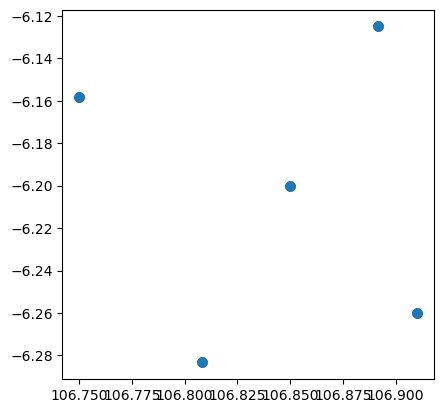

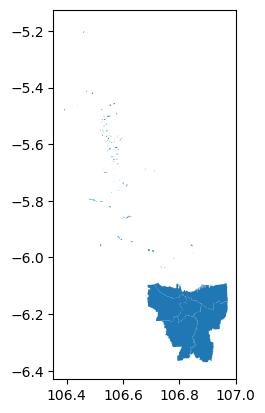

In [70]:
gdf_csv.plot()
gdf_shapefile.plot()

Spatial Join

In [71]:
#Join all the variables
result = gdf_csv.merge(gdf_shapefile, on = 'KABKOT')
result['geometry'] = result['geometry_y']
result = gpd.GeoDataFrame(result)
result_pop = result[['longitude', 'latitude','ispa_5y', 'year', 'KABKOT', 'geometry', 'time']]

<Axes: >

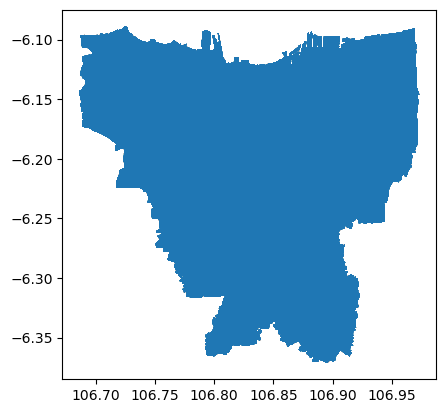

In [72]:
result_pop.plot()

Choosing Aggfun (Mean/Sum)

In [73]:
#aggfunc mean for polutan and iklim
#aggfunc sum for penyakit
dissolved_result = result_pop.dissolve(by=['KABKOT','year'], aggfunc='sum', numeric_only=True)
dissolved_result.reset_index(inplace=True)
dissolved_result.head()

,KABKOT,year,geometry,longitude,latitude,ispa_5y
0,JAKARTA BARAT,2018,"POLYGON Z ((106.71187 -6.09636 0.00000, 106.71...",1281.0,-73.9,246517
1,JAKARTA BARAT,2019,"POLYGON Z ((106.71187 -6.09636 0.00000, 106.71...",1281.0,-73.9,256221
2,JAKARTA BARAT,2020,"POLYGON Z ((106.71187 -6.09636 0.00000, 106.71...",1281.0,-73.9,138567
3,JAKARTA BARAT,2021,"POLYGON Z ((106.71187 -6.09636 0.00000, 106.71...",1281.0,-73.9,94588
4,JAKARTA BARAT,2022,"POLYGON Z ((106.71187 -6.09636 0.00000, 106.71...",1281.0,-73.9,183861


No Categories (Kasus,Suhu,RH)

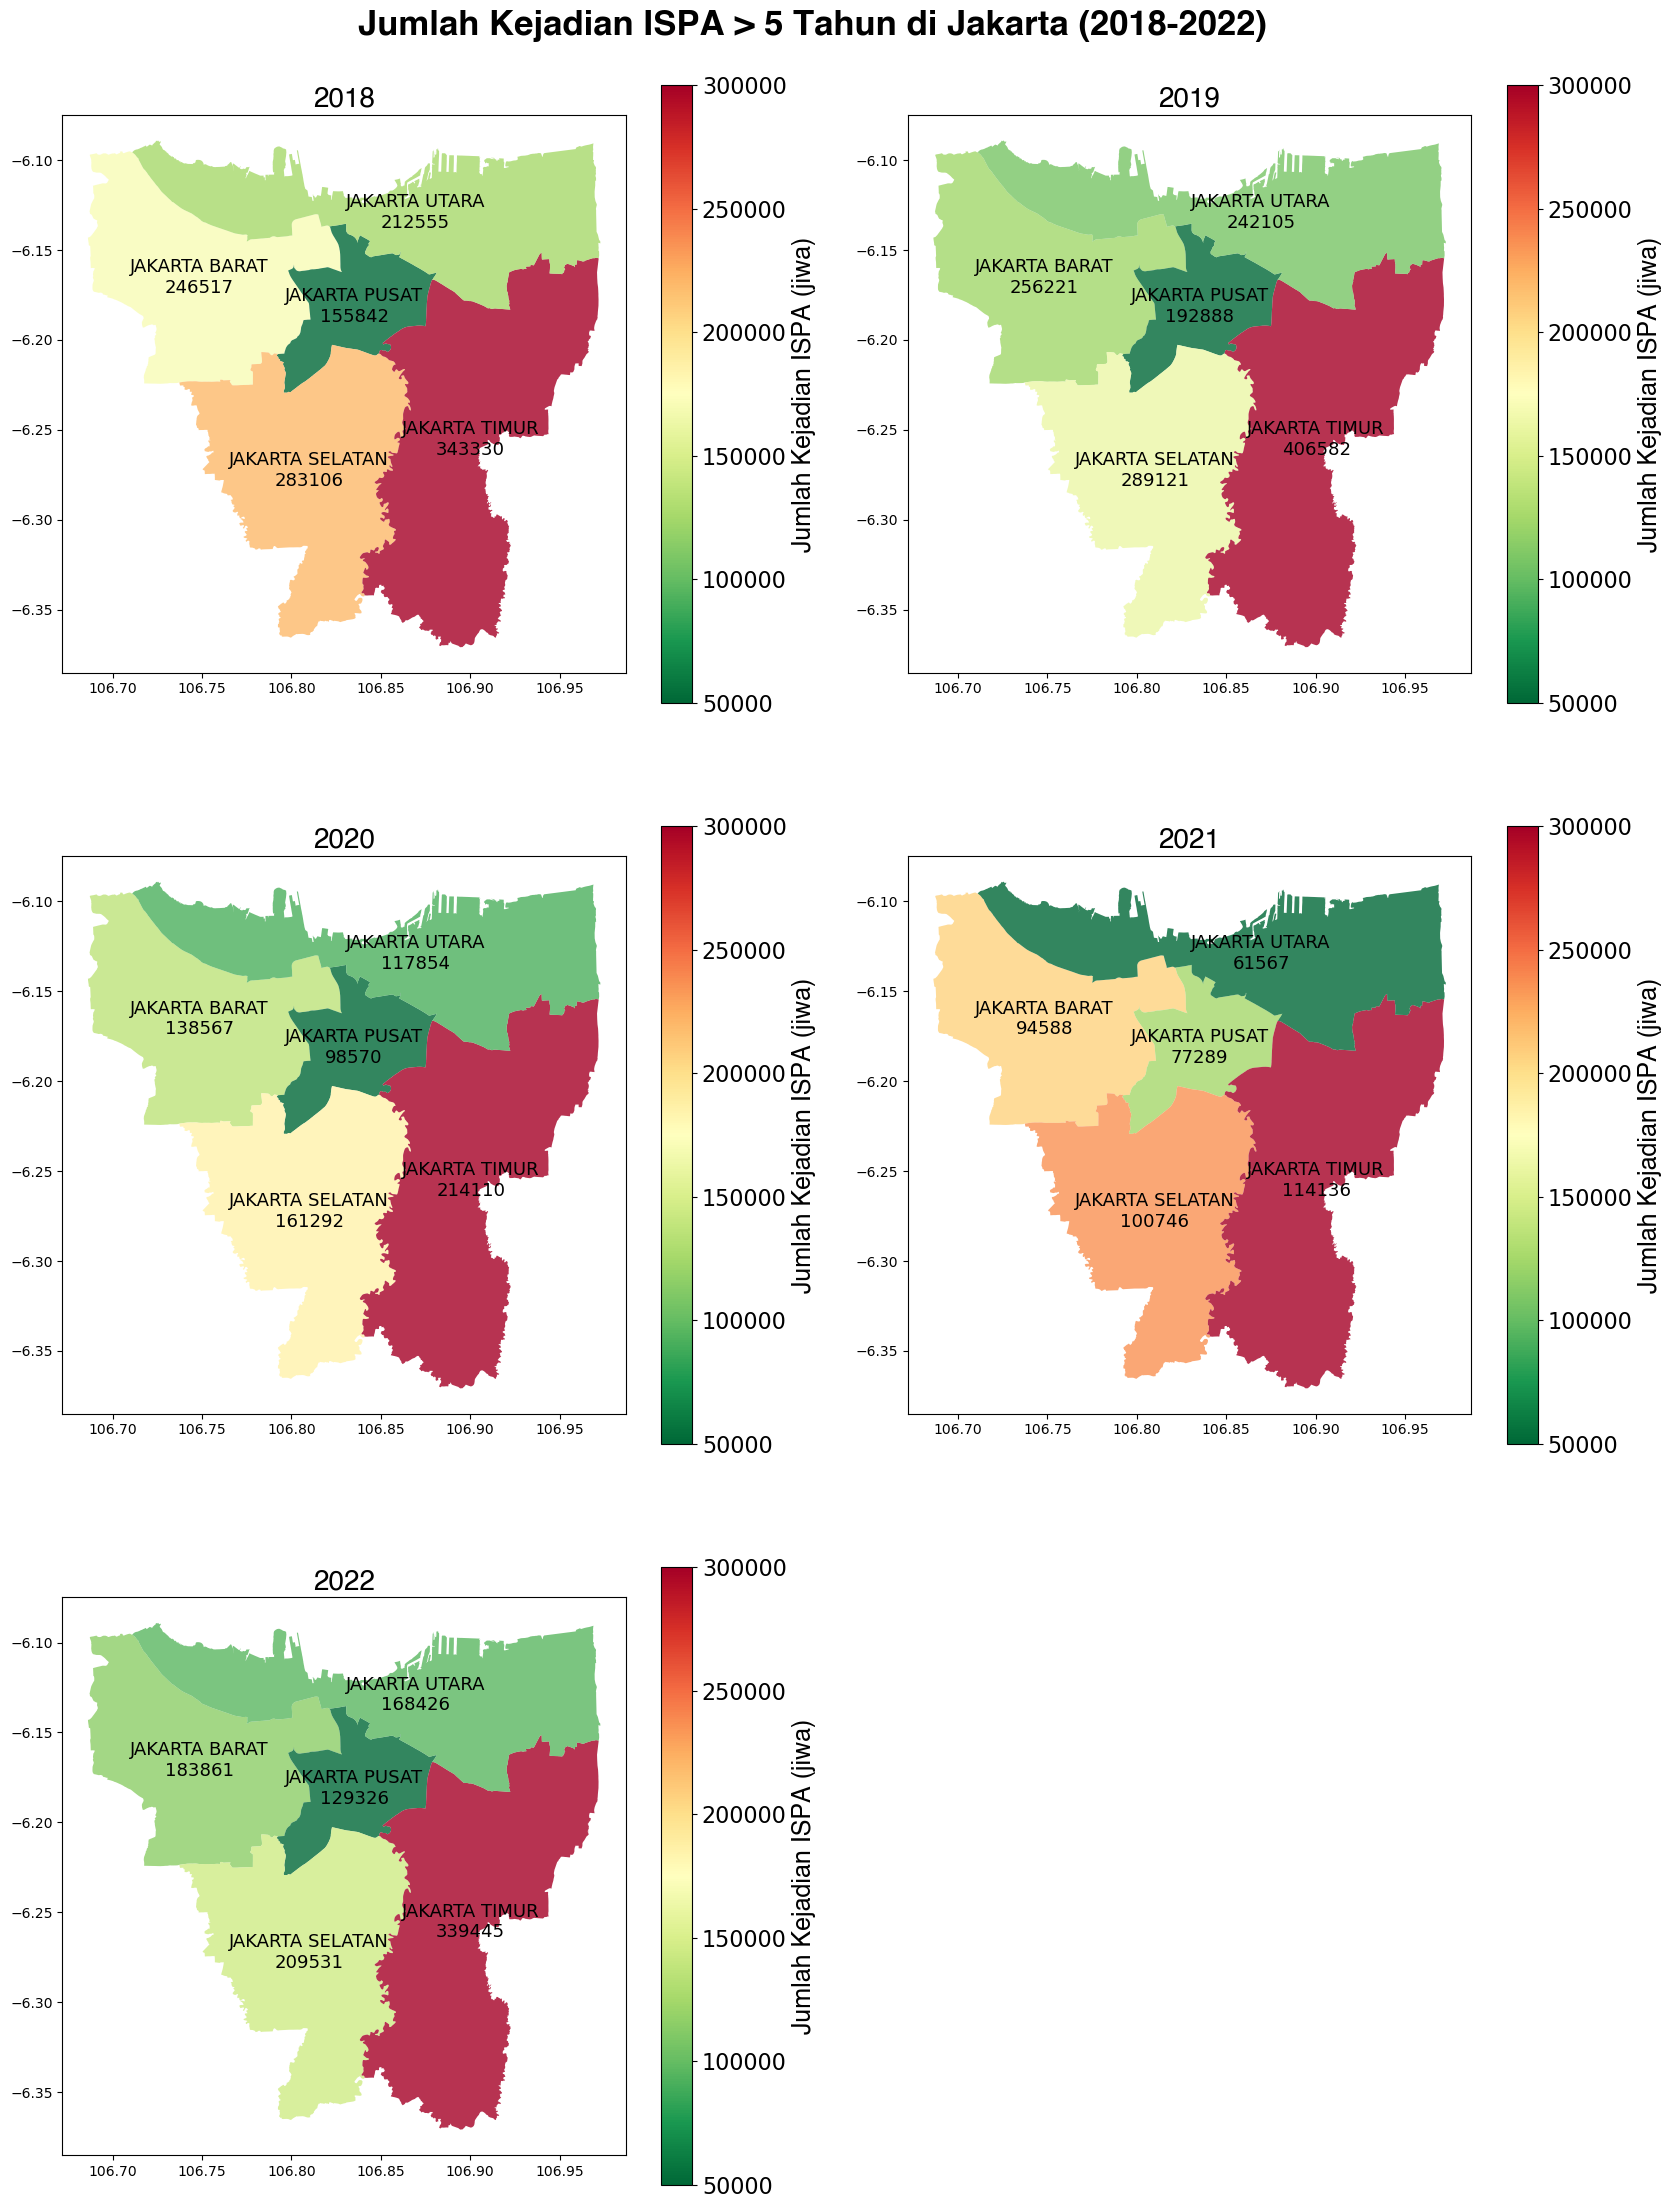

In [74]:
import calendar
import matplotlib.pyplot as plt

# Create a figure with subplots for each year
fig, axs = plt.subplots(3, 2, figsize=(20, 25))
fig.suptitle('Jumlah Kejadian ISPA > 5 Tahun di Jakarta (2018-2022)', font= 'Helvetica', weight= 'bold', fontsize=25)

# Iterate through each year and plot the data
for year, ax in zip(range(2018, 2023), axs.flatten()):
    # Filter data for the current year
    data_yearly = dissolved_result[dissolved_result['year'] == year]
    
    # Plot the map for the current year with custom color range
    data_yearly.plot(ax=ax, column="ispa_5y", cmap="RdYlGn_r", 
                     linewidth=0.8, alpha=0.8)

    # Annotate each polygon with average PM25 value and PSU category
    for idx, row in data_yearly.iterrows():
        nilai = row['ispa_5y']
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y,
                f"{row['KABKOT']}\n{nilai}",  #use :.2f for decimals
                fontsize=13, ha='center', va='center')

    ax.set_title(year, font= 'Helvetica',fontsize=20)  # Using the calendar module to get the month name

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=50000, vmax=300000))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label="Jumlah Kejadian ISPA (jiwa)")
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label("Jumlah Kejadian ISPA (jiwa)", font= 'Helvetica',fontsize=18)

# Remove unused subplots
for ax in axs.flatten()[len(range(2018, 2023)):]:
    ax.remove()

# Adjust layout
plt.subplots_adjust(hspace=0.2, top=0.95)  # Decrease the top parameter to reduce the space between title and subplots

# Show the plot
plt.show()

With Categories (PM, SO, TP)

KeyError: 'pm2p5'

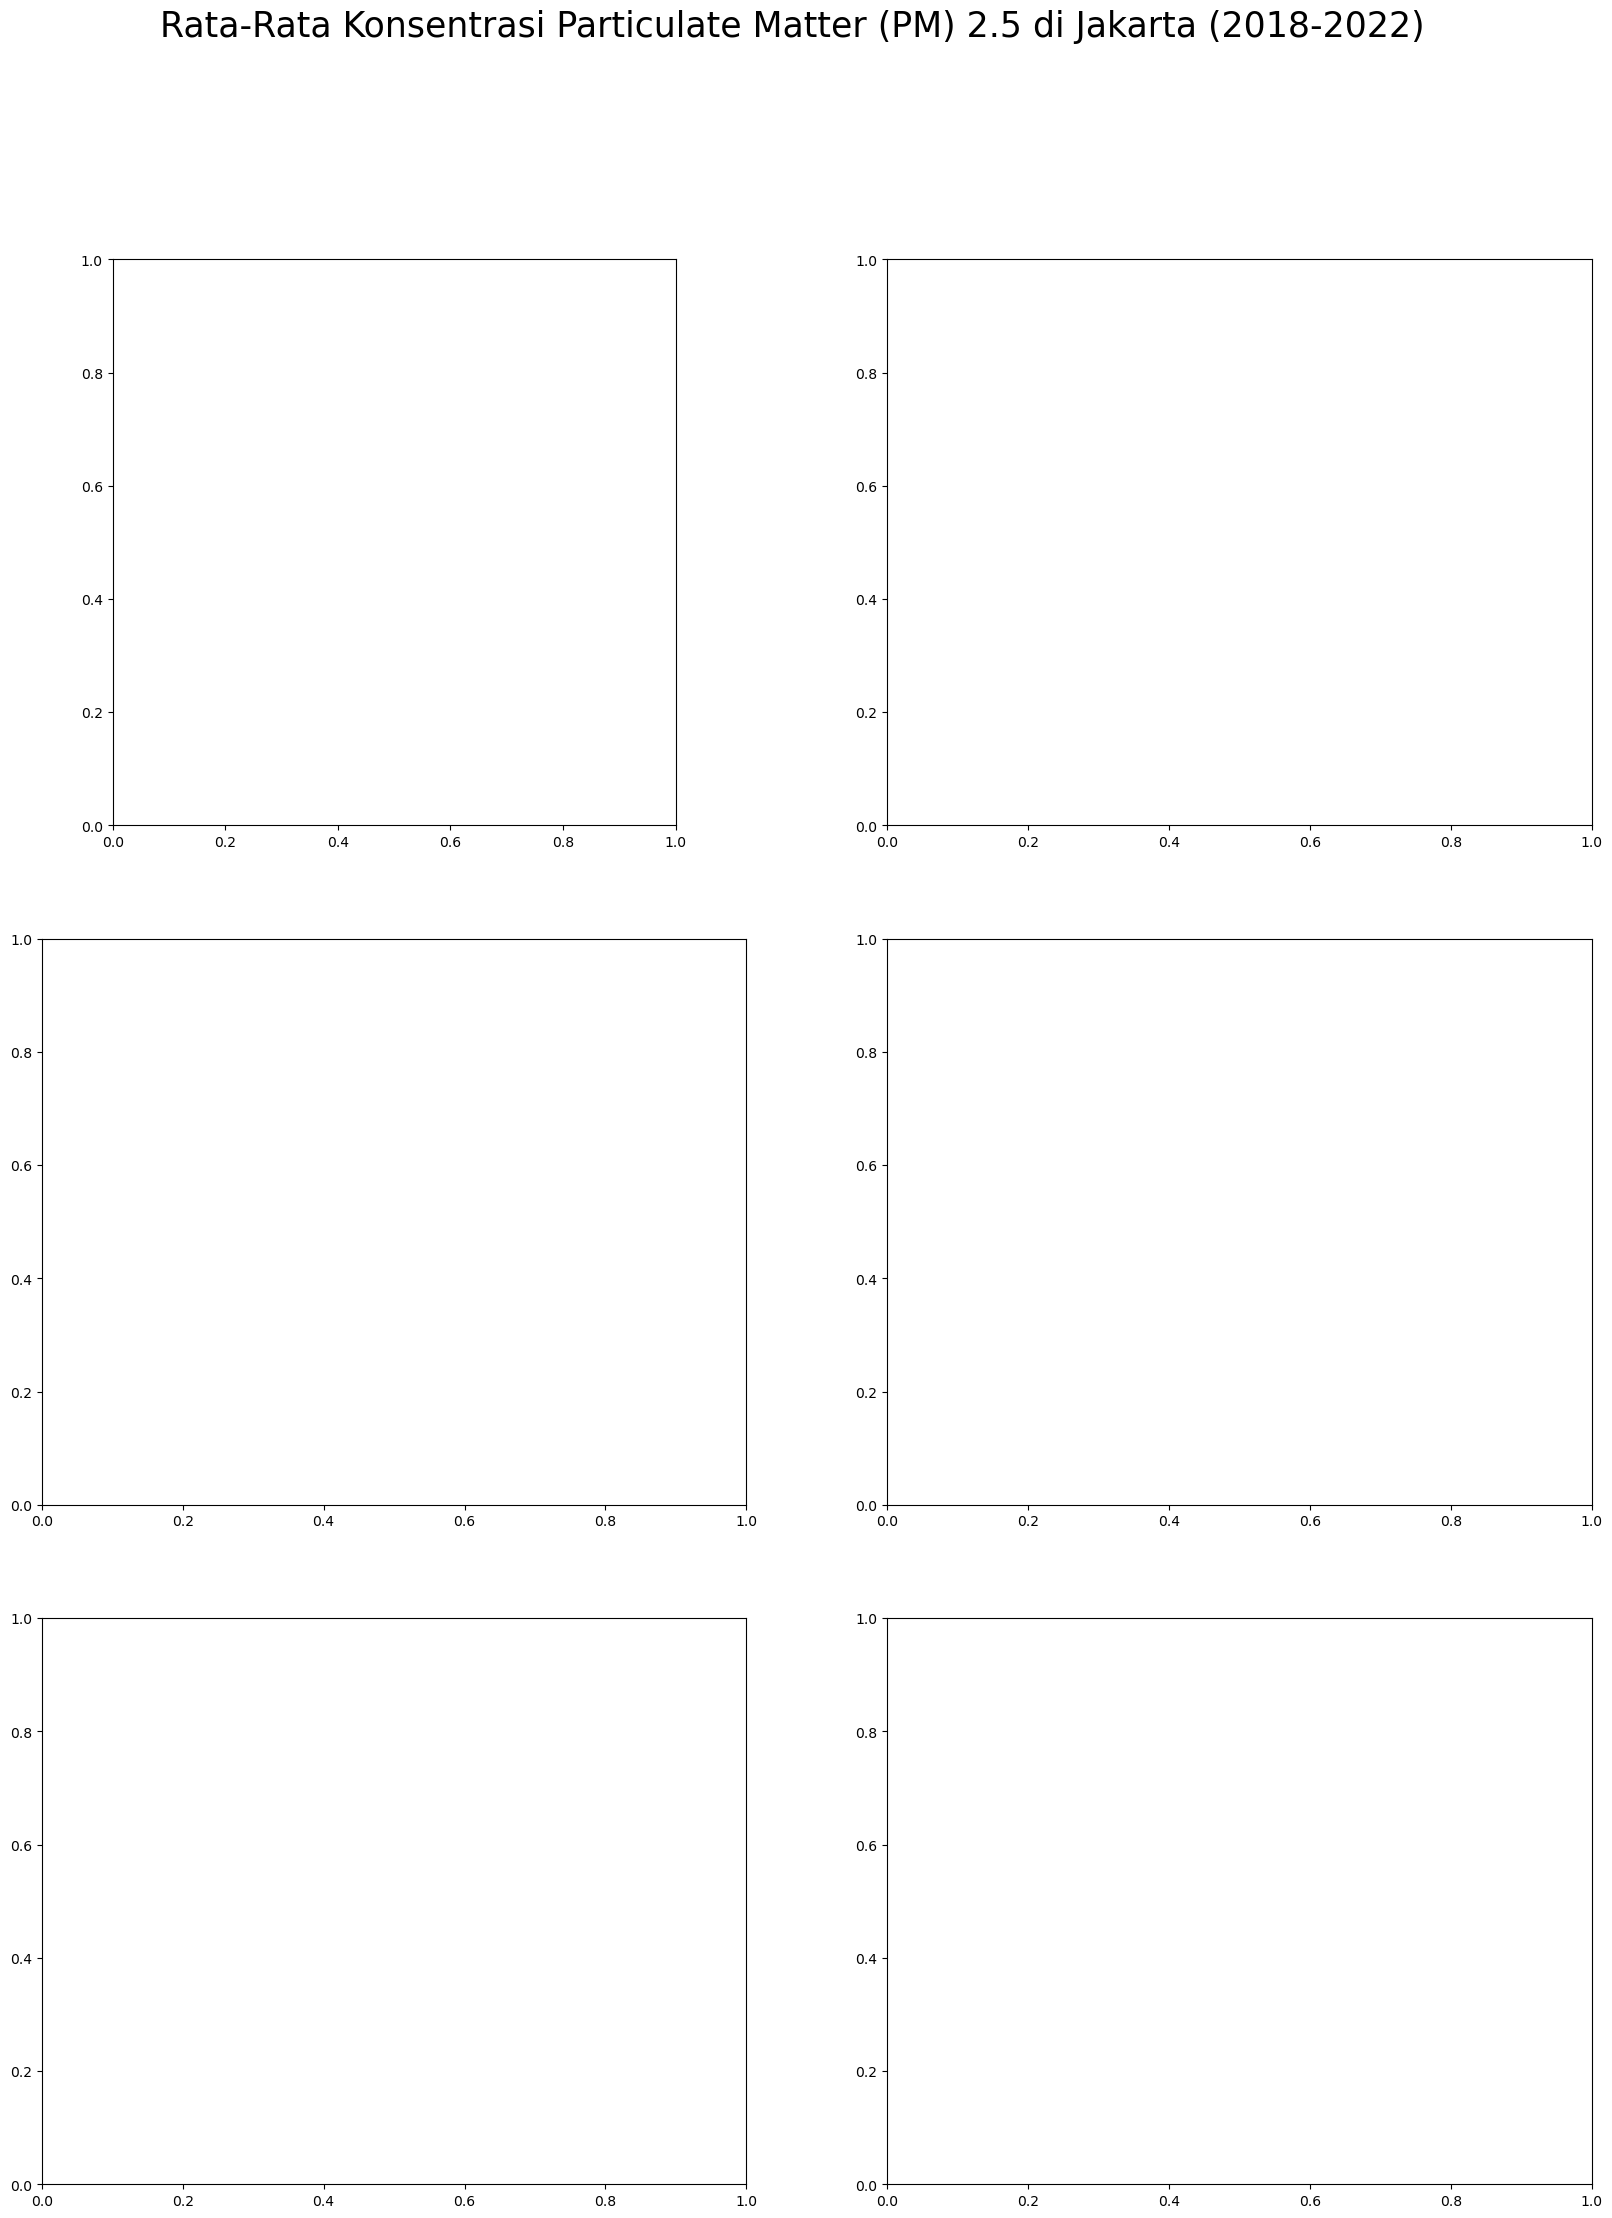

In [75]:
import calendar

# Function to determine the category based on PM2.5 value
def kategoriPSU(nilai):
    if nilai <= 15.5:
        return "Baik"
    elif nilai <= 55.4:
        return "Sedang"
    elif nilai <= 150.4:
        return "Tidak Sehat"
    elif nilai <= 250.4:
        return "Sangat Tidak Sehat"
    else:
        return "Berbahaya"

# Create a figure with subplots for each year
fig, axs = plt.subplots(3, 2, figsize=(20, 25))
fig.suptitle('Rata-Rata Konsentrasi Particulate Matter (PM) 2.5 di Jakarta (2018-2022)', fontsize=25)

# Iterate through each year and plot the data
for year, ax in zip(range(2018, 2023), axs.flatten()):
    # Filter data for the current year
    data_yearly = dissolved_result[dissolved_result['year'] == year]
    
    # Plot the map for the current year with custom color range
    data_yearly.plot(ax=ax, column="pm2p5", cmap="RdYlGn_r", 
                     linewidth=0.8, alpha=0.8)

    # Annotate each polygon with average PM25 value and PSU category
    for idx, row in data_yearly.iterrows():
        nilai = row['pm2p5']
        category = kategoriPSU(nilai)
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y,
                f"{row['KABKOT']}\n{nilai:.2f}\n({category})", 
                fontsize=13, ha='center', va='center')

    ax.set_title(year, fontsize=20)  # Using the calendar module to get the month name

    # Set colorbar limits
    vmin = 10
    vmax = 100

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label="Rata-Rata PM 2.5 (µg/m³)")
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label("Rata-Rata PM 2.5 (µg/m³)", fontsize=18)

# Remove unused subplots
for ax in axs.flatten()[len(range(2018, 2023)):]:
    ax.remove()

# Add a description to the right below the subplot on the third row
overall_description = f"Keterangan:\nBaik: 0 - 15.5 µg/m³\nSedang: 15.6 - 55.4 µg/m³\nTidak Sehat: 55.5 - 150.4 µg/m³\nSangat Tidak Sehat: 150.5 - 250.4 µg/m³\nBerbahaya: > 250.5 µg/m³"
fig.text(0.60, 0.20, overall_description, ha='left', fontsize=16, bbox=dict(facecolor='lightgrey', alpha=0.5))

# Adjust layout
plt.subplots_adjust(hspace=0.2, top=0.95)  # Decrease the top parameter to reduce the space between title and subplots

# Show the plot
plt.show()